## Titanic competition w/Tensorflow-Keras

#### Titanic - Machine Learning from Disaster

`titanic,
    author = {Will Cukierski},
    title = {Titanic - Machine Learning from Disaster},
    publisher = {Kaggle},
    year = {2012},
    url = {https://kaggle.com/competitions/titanic}
`

In [61]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import pandas as pd
import numpy as np
import warnings
import re
import inspect
import math
warnings.filterwarnings('ignore')

In [62]:
# Regression runs
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score


In [63]:
import tensorflow as tf
def gpu_setup():
    # Detect GPUs, return appropriate strategy
    gpus = tf.config.experimental.list_physical_devices('GPU')
    
    if gpus:
        try:
            # setup up GPU memory growth as True for each GPU
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            strategy = tf.distribute.MirroredStrategy()
            print(f'using: {len(gpus)}')
        except:
            strategy = tf.distribute.get_strategy()
            
        return strategy


# Setting GPU strategy for this session
## replicas = gpu_setup()
# print("REPLICAS: ", replicas.num_replicas_in_sync)
!nvidia-smi

Sun Jan 14 11:27:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.13                 Driver Version: 537.13       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1660 Ti   WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   48C    P8               7W /  80W |   4531MiB /  6144MiB |      6%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [64]:
train_df = pd.read_csv('../datasets/guru/train.csv')
test_df = pd.read_csv('../datasets/guru/test.csv')

In [65]:
# train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
# test_df = pd.read_csv('/kaggle/input/titanic/test.csv')

In [66]:
def print_null(DF:pd.core.frame.DataFrame):
    print(DF.isnull().sum())


In [67]:
print_null(train_df)
print_null(test_df)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [68]:
train_df.dropna(subset=['Embarked'], inplace=True)        # drop 2 rows
train_df.dropna(subset=['Fare'], inplace=True)

test_df.dropna(subset=['Embarked'], inplace=True)
test_df.dropna(subset=['Fare'], inplace=True)             # drop one row


In [69]:
train_df[(train_df['Age'].isnull() & train_df['Cabin'].isnull() )]
test_df[(test_df['Age'].isnull() & test_df['Cabin'].isnull() )]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
10,902,3,"Ilieff, Mr. Ylio",male,NaN,0,0,349220,7.8958,NaN,S
22,914,1,"Flegenheim, Mrs. Alfred (Antoinette)",female,NaN,0,0,PC 17598,31.6833,NaN,S
29,921,3,"Samaan, Mr. Elias",male,NaN,2,0,2662,21.6792,NaN,C
33,925,3,"Johnston, Mrs. Andrew G (Elizabeth Lily"" Watson)""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
36,928,3,"Roth, Miss. Sarah A",female,NaN,0,0,342712,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
408,1300,3,"Riordan, Miss. Johanna Hannah""""",female,NaN,0,0,334915,7.7208,NaN,Q
410,1302,3,"Naughton, Miss. Hannah",female,NaN,0,0,365237,7.7500,NaN,Q
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [70]:
# update solumns 'SibSp' and 'Parch' with '0' entries to 1 
# assuming at least one member in party
train_df.SibSp = train_df.SibSp.replace({0:1})
train_df.Parch = train_df.Parch.replace({0:1})

test_df.SibSp = test_df.SibSp.replace({0:1})
test_df.Parch = test_df.Parch.replace({0:1})

In [71]:
# cleanup - 'Cabin' in both Train and Test sets
# Cabin has mixed entries + entries with spaces and some NaN
print('\nClean up "Cabin" column - remove NaNs and parse Cabin names')
# print(train_df['Cabin'].value_counts())
print(train_df['Cabin'].isna().sum())
print(test_df['Cabin'].isna().sum())


Clean up "Cabin" column - remove NaNs and parse Cabin names
687
326


In [72]:
# Convert 'Cabin' to single Alphabets to denote floor of Titanic
# Change Null values to 'T' - this takes care of Cabin value 'T' not in test set
train_df.Cabin = train_df.Cabin.fillna('T')
test_df.Cabin = test_df.Cabin.fillna('T')

In [73]:
# compress values in 'Cabin' to a Aplhabet
train_df['Cabin'] = train_df['Cabin'].map(lambda x: re.sub("\d+","", x))
train_df['Cabin'] = train_df['Cabin'].map(lambda x: re.sub("\s+","", x))
train_df['Cabin'] = train_df['Cabin'].map(lambda x: re.sub(r'(.)\1+', r'\1',x))

test_df['Cabin'] = test_df['Cabin'].map(lambda x: re.sub("\d+","", x))
test_df['Cabin'] = test_df['Cabin'].map(lambda x: re.sub("\s+","", x))
test_df['Cabin'] = test_df['Cabin'].map(lambda x: re.sub(r'(.)\1+', r'\1',x))

print(test_df.Cabin.unique())
print(train_df.Cabin.unique())

['T' 'B' 'E' 'A' 'C' 'D' 'FG' 'F' 'G' 'FE']
['T' 'C' 'E' 'G' 'D' 'A' 'B' 'F' 'FG' 'FE']


In [74]:
# correlation matrix for few of the columns
train_df[['Pclass', 'Age', 'SibSp', 'Parch', 'Survived']].corr(numeric_only=True)

,Pclass,Age,SibSp,Parch,Survived
Pclass,1.000000,-0.365902,0.149429,0.052323,-0.335549
Age,-0.365902,1.000000,-0.326339,-0.066554,-0.082446
SibSp,0.149429,-0.326339,1.000000,0.238055,-0.109144
Parch,0.052323,-0.066554,0.238055,1.000000,0.006604
Survived,-0.335549,-0.082446,-0.109144,0.006604,1.000000


In [75]:
# check survival of Parents with Children and Siblings/Spuses in table format as well as plot
print("\ncheck survival of Parents with Children and Siblings/Spuses in table format")
print(train_df[['Parch','SibSp','Pclass','Age','Survived']].groupby(['Parch','SibSp']).mean(numeric_only=True).sort_values(by='Survived', ascending=True))

# create target data from train_df.Survived
print("drop 'PassengerId', 'Name', 'Ticket', 'Fare' from train_df")
y_train = train_df['Survived']
train_df.drop(['PassengerId', 'Survived','Name','Ticket','Fare'], axis=1, inplace=True)


check survival of Parents with Children and Siblings/Spuses in table format
               Pclass        Age  Survived
Parch SibSp                               
1     4      3.000000   6.777778  0.000000
2     5      3.000000  10.200000  0.000000
      8      3.000000        NaN  0.000000
4     1      2.500000  44.500000  0.000000
6     1      3.000000  43.000000  0.000000
5     1      3.000000  39.200000  0.200000
1     3      2.888889  15.200000  0.222222
2     3      2.142857  13.000000  0.285714
      4      3.000000   7.333333  0.333333
1     1      2.288181  31.499025  0.377158
      2      2.434783  23.625000  0.434783
2     2      2.000000  17.250000  0.500000
3     1      2.750000  35.500000  0.500000
2     1      2.000000  20.784884  0.687500
3     2      2.000000  24.000000  1.000000
drop 'PassengerId', 'Name', 'Ticket', 'Fare' from train_df


In [76]:
# Now we have 7 columns in Train dataset and shape (891,7)
print(train_df.columns,'\n',train_df.shape)

# now from Test data create PassengerId dataset
print("\ndrop 'PassengerId', 'Name', 'Ticket', 'Fare' from test_df")
# test_df has no 'Survived' column
passengerId = test_df['PassengerId']
test_df.drop(['PassengerId', 'Name','Ticket','Fare'], axis=1, inplace=True)

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Cabin', 'Embarked'], dtype='object') 
 (889, 7)

drop 'PassengerId', 'Name', 'Ticket', 'Fare' from test_df


In [77]:
print(train_df.shape,test_df.shape)

(889, 7) (417, 7)


In [78]:
print(train_df.head())
print(test_df.head())

   Pclass     Sex   Age  SibSp  Parch Cabin Embarked
0       3    male  22.0      1      1     T        S
1       1  female  38.0      1      1     C        C
2       3  female  26.0      1      1     T        S
3       1  female  35.0      1      1     C        S
4       3    male  35.0      1      1     T        S
   Pclass     Sex   Age  SibSp  Parch Cabin Embarked
0       3    male  34.5      1      1     T        Q
1       3  female  47.0      1      1     T        S
2       2    male  62.0      1      1     T        Q
3       3    male  27.0      1      1     T        S
4       3  female  22.0      1      1     T        S


In [79]:
print(train_df['Cabin'].isna().sum())
print(test_df['Cabin'].isna().sum())

0
0


In [80]:
print('Train cabin:', len(train_df['Cabin'].unique()))
print('Train embarked:', len(train_df['Embarked'].unique()))

print('\nTrain gender:', len(train_df['Sex'].unique()))
print('Test gender:', len(test_df['Sex'].unique()))

print('\nTest cabin:', len(test_df['Cabin'].unique()))
print('Test embarked:', len(test_df['Embarked'].unique()))

Train cabin: 10
Train embarked: 3

Train gender: 2
Test gender: 2

Test cabin: 10
Test embarked: 3


In [81]:
# work on Age
print('\nWork on "Age" column - convert NaNs to most values based on mean and 50% quantile')
#   we will use the mean and quantile from train set for training
#   we will use the mean and quantile from test set for predicting
train_mean_age = train_df['Age'].mean(numeric_only=True)
test_mean_age = test_df['Age'].mean(numeric_only=True)
train_quant_age = train_df['Age'].quantile(0.75)
test_quant_age = test_df['Age'].quantile(0.75)
print(train_mean_age, train_quant_age)
print(test_mean_age, test_quant_age)

ma = train_mean_age
mb = train_quant_age
if train_mean_age > train_quant_age:
    mb = ma
    ma = train_quant_age

train_df['Age'] = train_df.apply(
    lambda row: np.random.randint(ma, mb) if np.isnan(row['Age']) else row['Age'], axis=1
)
test_df['Age'] = test_df.apply(
    lambda row: np.random.randint(ma, mb) if np.isnan(row['Age']) else row['Age'], axis=1
)


print(train_df['Age'].isna().sum())
print(test_df['Age'].isna().sum())


Work on "Age" column - convert NaNs to most values based on mean and 50% quantile
29.64209269662921 38.0
30.181268882175228 39.0
0
0


In [82]:
# check entries in both Train and Test datasets
print_null(train_df)
print_null(test_df)

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Cabin       0
Embarked    0
dtype: int64
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Cabin       0
Embarked    0
dtype: int64


In [83]:
print('Train gender:', len(train_df['Sex'].unique()))
print('Train cabin:', len(train_df['Cabin'].unique()))
print('Train embarked:', len(train_df['Embarked'].unique()))
print('Test gender:', len(test_df['Sex'].unique()))
print('Test cabin:', len(test_df['Cabin'].unique()))
print('Test embarked:', len(test_df['Embarked'].unique()))

Train gender: 2
Train cabin: 10
Train embarked: 3
Test gender: 2
Test cabin: 10
Test embarked: 3


In [84]:
print(train_df.shape, test_df.shape)
train_df = pd.get_dummies(train_df)
test_df = pd.get_dummies(test_df)
print(train_df.shape, test_df.shape)

(889, 7) (417, 7)
(889, 19) (417, 19)


In [85]:
# before split drop columns that don't match between train and test
for i in train_df.columns:
    # print(f'column:-{i}-')
    if i not in test_df.columns:
        print(f'column:-{i}- does not exist in test_df')
        # train_df.drop(i, inplace=True, axis=1)
        raise Exception(f'column:-{i}- does not exist in test_df')

for i in test_df.columns:
    # print(f'column:-{i}-')
    if i not in train_df.columns:
        print(f'column:-{i}- does not exist in train_df')
        # test_df.drop(i, inplace=True, axis=1)
        raise Exception(f'column:-{i}- does not exist in test_df')


print(train_df.shape, test_df.shape)

(889, 19) (417, 19)


In [86]:
train_df[:10]

,Pclass,Age,SibSp,Parch,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_FE,Cabin_FG,Cabin_G,Cabin_T,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
1,1,38.0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,3,26.0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,1,35.0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,3,35.0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
5,3,37.0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
6,1,54.0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
7,3,2.0,3,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
8,3,27.0,1,2,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
9,2,14.0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0


In [87]:
# convert True/False to 1 & 0
train_df = train_df.replace({True: 1, False: 0})
test_df = test_df.replace({True: 1, False: 0})

In [88]:
# train_df = train_df_copy.copy()
print(train_df.shape, test_df.shape)

(889, 19) (417, 19)


In [89]:
train_df[:10]

,Pclass,Age,SibSp,Parch,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_FE,Cabin_FG,Cabin_G,Cabin_T,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
1,1,38.0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,3,26.0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,1,35.0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,3,35.0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
5,3,37.0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
6,1,54.0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
7,3,2.0,3,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
8,3,27.0,1,2,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
9,2,14.0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0


In [90]:
test_df[:10]

,Pclass,Age,SibSp,Parch,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_FE,Cabin_FG,Cabin_G,Cabin_T,Embarked_C,Embarked_Q,Embarked_S
0,3,34.5,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
1,3,47.0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
2,2,62.0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
3,3,27.0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
4,3,22.0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
5,3,14.0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
6,3,30.0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0
7,2,26.0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
8,3,18.0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0
9,3,21.0,2,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1


In [91]:
# train_df_copy = train_df.copy()

In [92]:
train_df.max(axis=0).max()

80.0

In [93]:
# scale all values of train_df between 0 amd max value over all columns
# train_df.max(axis=0).max()
train_df /= train_df.max(axis=0).max()
test_df /= test_df.max(axis=0).max()

In [94]:
train_df.head()

,Pclass,Age,SibSp,Parch,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_FE,Cabin_FG,Cabin_G,Cabin_T,Embarked_C,Embarked_Q,Embarked_S
0,0.0375,0.2750,0.0125,0.0125,0.0000,0.0125,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0125,0.0000,0.0,0.0125
1,0.0125,0.4750,0.0125,0.0125,0.0125,0.0000,0.0,0.0,0.0125,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0125,0.0,0.0000
2,0.0375,0.3250,0.0125,0.0125,0.0125,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0125,0.0000,0.0,0.0125
3,0.0125,0.4375,0.0125,0.0125,0.0125,0.0000,0.0,0.0,0.0125,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0125
4,0.0375,0.4375,0.0125,0.0125,0.0000,0.0125,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0125,0.0000,0.0,0.0125


In [95]:
# split train dataset into train and validation datasets
# train_df_copy = train_df.copy()
train_X, val_X, train_y, val_y = train_test_split(train_df, 
                                                  y_train, 
                                                  test_size=0.3, 
                                                  random_state=42,
                                                 shuffle=False)

In [96]:
print(train_X.shape, val_X.shape, test_df.shape)

(622, 19) (267, 19) (417, 19)


In [97]:
### Deep learning Neural Networks using TensorFlow / Keras
print('\nDeep learning Neural Networks using TensorFlow / Keras Binary Classification')
import tensorflow as tf
from tensorflow import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Dropout, BatchNormalization, Flatten
from keras.optimizers import Adam
from keras.constraints import MaxNorm

from keras.losses import CategoricalCrossentropy
from keras.utils import plot_model


Deep learning Neural Networks using TensorFlow / Keras Binary Classification


In [120]:
batch_size = 32
epoch_num = 50
num_layers = 4
dropout = 0.6
neurons = 512
activation = 'relu'
optimizer = 'Adam'
weight_constraint = 4.0
init_mode = 'he_normal'
momentum = 0.9
learn_rate = 0.001

print(
    f"{'neurons:':<15}{neurons:>10}",
    f"{'num_layers:':<15}{num_layers:>10}",
    f"{'batch:':<15}{batch_size:>10}",
    f"{'epoch:':<15}{epoch_num:>10}",
    sep='\n'
)

# default values to setup a Keras model
best_learning_rate       = learn_rate  # 0.001
best_momentum            = momentum  # 0.1
best_init_mode           = init_mode # 'he_normal'
best_activation          = activation
best_dropout             = dropout  # 0.2
best_weight_constraint   = weight_constraint  # 4.0
best_neurons             = neurons  # 256
best_optimizer           = optimizer
best_epoch_num           = epoch_num
best_batch_size          = batch_size
best_num_hidden_layers   = num_layers

# input dataframe
inputdf=train_X         # define the dataframe to use for input_shape - Neural Networks only need number of features


neurons:              512
num_layers:             4
batch:                 32
epoch:                 50


#### print best values
print('best_optimizer: ', optimizer)
print('best_neurons: ', neurons)
print('best_num_hidden_layers: ', num_layers)
print('best_weight_constraint: ', weight_constraint)
print('best_dropout: ', dropout)
print('best_activation: ', activation)
print('best_init_mode: ', init_mode)
print('best_learning_rate: ', learn_rate)
print('best_momentum: ', momentum)
print('best_epoch_num: ', epoch_num)
print('best_batch_size: ', batch_size)

In [121]:
def create_hyper_model(lr=best_learning_rate,
                       momentum=best_momentum,
                       init_mode=best_init_mode,
                       activation=best_activation,
                       dropout=best_dropout,
                       weight_constraint=best_weight_constraint,
                       neurons=best_neurons,
                       optimizer=best_optimizer,
                       num_hidden_layers=best_num_hidden_layers,
                      inputdf=inputdf):
    
    # clear model session and recreate - 
    # according to Keras docs works for a functional model
    keras.backend.clear_session()
    dense_dict = inspect.signature(Dense)
    dropout_dict = inspect.signature(Dropout)
    batch_norm_dict = inspect.signature(BatchNormalization)
    
    ###################################################
    # get defaults for hyper-search parameter values
    ###################################################
    # ValueError: Unknown initializer: 'glorot_uniform'. 
    # Please ensure this object is passed to the `custom_objects` argument.
    if init_mode is None:
        k = 'kernel_initializer'
        # val = str(dense_dict.parameters[k]).split('=')[1]
        init_mode = str(dense_dict.parameters[k]).split('=')[1] 
        init_mode = 'glorot_normal'

    if activation is None:
        k = 'activation'
        # val = str(dense_dict.parameters[k]).split('=')[1]
        activation = str(dense_dict.parameters[k]).split('=')[1] 
         
    if weight_constraint is None:
        k = 'kernel_constraint'
        # val = str(dense_dict.parameters[k]).split('=')[1]
        # weight_constraint = str(dense_dict.parameters[k]).split('=')[1] 
        weight_constraint = 4.0

    if lr is None:    # learning_rate - optimizer
        lr = 0.001
    
    if momentum is None:
        k = 'momentum'
        # val = str(dense_dict.parameters[k]).split('=')[1]
        momentum = np.float32(str(batch_norm_dict.parameters[k]).split('=')[1])
        # momentum = 0.1

    if dropout is None:
        dropout = 0.2

    ###################################################
    # function to return a list of layers depending on the 
    # number asked and number_of_neurons in first layer
    ###################################################
    def return_num_layers(nn_num=neurons, n_layers=num_hidden_layers):
        layers = []

        divn = 1 if n_layers <= 1 else (n_layers -1)
        # first layer to contain all neurons
        first_lyr_units = neurons

        # last layer (before output) is:
        last_lyr_units = neurons // n_layers
        
        incr_by = (last_lyr_units - first_lyr_units) / divn
        num_neurons = first_lyr_units
        
        # print(f'num_neurons:{num_neurons} - incr_by:{incr_by}')
        for i in range(1, n_layers + 1):
            layers.append(round(math.ceil(num_neurons)))
            # print(f'layer:{i} - num_neurons:{num_neurons} - layers:{layers}')
            num_neurons = num_neurons + incr_by

        return layers

    
    # neurons = math.ceil(neurons)
    neurons = math.ceil(inputdf.shape[1] * (best_batch_size / 2) )
    num_lyrs = return_num_layers(neurons, num_hidden_layers)
    # print('num_lyrs ', num_lyrs)
    
    ###################################################
    # create model
    ###################################################
    model = Sequential()
    # model.add(Input(shape=(inputdf.shape[1],)))   # used in functional

    model.add(Dense(num_lyrs[0] * 2, input_shape=(inputdf.shape[1],), 
                    kernel_initializer=init_mode, activation=activation,
                    kernel_constraint=MaxNorm(weight_constraint)))

    if momentum > 0.5:
        model.add(BatchNormalization(momentum=momentum))

    if len(num_lyrs) > 2:
        for i in range(1, num_hidden_layers -1):
            model.add(Dense(num_lyrs[i -1] * ( i / num_hidden_layers ), 
                            kernel_initializer=init_mode, activation=activation,
                            kernel_constraint=MaxNorm(weight_constraint)))
    
    # model.add(Dense(neurons//2, kernel_initializer=init_mode, activation=activation,
    #               kernel_constraint=MaxNorm(weight_constraint)))

    if dropout > 0.1:
        model.add(Dropout(dropout))

    # model.add(Flatten())
    if len(num_lyrs) > 1:
        model.add(Dense(num_lyrs[-1], kernel_initializer=init_mode, activation=activation,
                        kernel_constraint=MaxNorm(weight_constraint)))
    
    model.add(Dense(1, kernel_initializer=init_mode, activation='sigmoid'))
    ###################################################
    
    # Compile model
    opt=keras.optimizers.get(optimizer)   # opt.__dir__ to know what can be set
    opt.learning_rate=lr
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [116]:
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy',     # monitor vlidation loss    
                                         min_delta=0.05,             # min change in monitored qty
                                         patience=35,                 # of epochs to wait after metric is met
                                         mode='max',                 # 'min' stopped decreasing, 'max' stopped increasing (default 'auto')
                                         verbose=1,                  # '1' - display msgs when callback takes an action
                                         restore_best_weights=True,  # whether to restore model weights:
                                         )



In [117]:
# set initial - default learning_rate
LEARNING_RATE = 0.01

# learning rate scheduling
def lr_scheduler(epoch):
    global LEARNING_RATE
    if epoch < 10:
        LEARNING_RATE += 1e-7   # 1e-7
    else:
        LEARNING_RATE *= tf.math.exp(-0.004)  # tf.math.exp(-0.1) 
    
    # LEARNING_RATE *= tf.math.exp(-0.1)
    
    return LEARNING_RATE

lr_callback = tf.keras.callbacks.LearningRateScheduler(
    lr_scheduler, 
    verbose=True,
)

In [118]:
# # set initial - default learning_rate
# LEARNING_RATE = 3e-5

# # learning rate scheduling
# def lr_scheduler(epoch):
#     global LEARNING_RATE
#     if epoch < 10:
#         LEARNING_RATE += 1e-8   # 1e-7
#     else:
#         LEARNING_RATE *= tf.math.exp(-0.1)  # tf.math.exp(-0.1) 
    
#     # LEARNING_RATE *= tf.math.exp(-0.1)
    
#     return LEARNING_RATE

# lr_callback = tf.keras.callbacks.LearningRateScheduler(
#     lr_scheduler, 
#     verbose=True,
# )

In [122]:
# usign callback to limit run time
# del model
model = create_hyper_model()
model.summary()
history = model.fit(train_X, train_y, 
                    batch_size=64, 
                    epochs=70, 
                    validation_data=(val_X, val_y),
                    verbose=1,
                    callbacks=[callback, lr_callback],
                   )
# callbacks=[callback, lr_callback],

# train_X, val_X, train_y, val_y
# Training stopped early due to setting of callback
model_eval = model.evaluate(train_X, train_y)
print('evaluate train_X:', model_eval)

model_eval = model.evaluate(val_X, val_y)
print('evaluate val_X: ', model_eval)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 608)               12160     
                                                                 
 batch_normalization (BatchN  (None, 608)              2432      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 76)                46284     
                                                                 
 dense_2 (Dense)             (None, 114)               8778      
                                                                 
 dropout (Dropout)           (None, 114)               0         
                                                                 
 dense_3 (Dense)             (None, 76)                8740      
                                                        

In [123]:
# predict on validation dataset
val_pred_model = model.predict(val_X)

# print(val_pred_model)
val_predicted = [0 if pred < 0.5 else 1 for pred in val_pred_model]
print('\nNeural Nets - report on Confusion matrix, Classification report, Accuracy and F1 scores')
print(confusion_matrix(val_y, val_predicted))
print(classification_report(val_y, val_predicted))

print(f'Accuracy Score: {accuracy_score(val_y, val_predicted):.2f}')
print(f'F1 Score: {f1_score(val_y, val_predicted):.2f}')

9/9 [==============================] - 0s 3ms/step

Neural Nets - report on Confusion matrix, Classification report, Accuracy and F1 scores
[[157  15]
 [ 24  71]]
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       172
           1       0.83      0.75      0.78        95

    accuracy                           0.85       267
   macro avg       0.85      0.83      0.84       267
weighted avg       0.85      0.85      0.85       267

Accuracy Score: 0.85
F1 Score: 0.78


<AxesSubplot:>

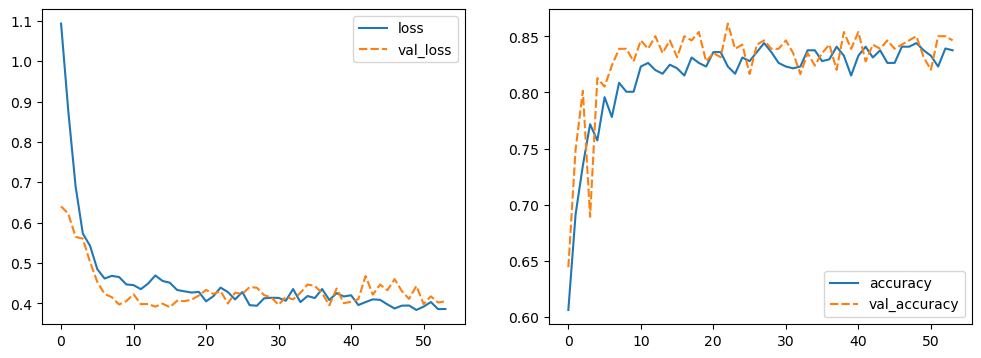

In [124]:
# from Petals to Metals 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

hist_frame=pd.DataFrame(data=history.history)

plt.figure(figsize=(12,9))
plt.subplot(2,2,1)
sns.lineplot(data=(hist_frame.loss, hist_frame.val_loss))
plt.subplot(2,2,2)
sns.lineplot(data=(hist_frame.accuracy, hist_frame.val_accuracy))

In [126]:
# now predict on Test dataset and copy to CSV
test_model_predictions = model.predict(test_df)
print(test_model_predictions)
test_model_data = pd.DataFrame()
test_model_data['PassengerId'] = passengerId
test_model_data['Survived'] = [0 if pred < 0.5 else 1 for pred in test_model_predictions]
test_model_data.to_csv('gender_submission.csv', index = False)


14/14 [==============================] - 0s 3ms/step
[[0.17034017]
 [0.40342495]
 [0.12684964]
 [0.16580178]
 [0.40435717]
 [0.2649207 ]
 [0.8326013 ]
 [0.23766272]
 [0.44270632]
 [0.12107201]
 [0.1439699 ]
 [0.27277753]
 [0.99416673]
 [0.09611529]
 [0.99975854]
 [0.87693787]
 [0.25049958]
 [0.22346298]
 [0.4252961 ]
 [0.4290294 ]
 [0.23287407]
 [0.44896215]
 [0.99313325]
 [0.35128516]
 [0.99755305]
 [0.11368218]
 [0.9944871 ]
 [0.21305852]
 [0.3084406 ]
 [0.10608847]
 [0.16284214]
 [0.16367255]
 [0.43379456]
 [0.4196194 ]
 [0.31377894]
 [0.24488705]
 [0.46011546]
 [0.40272892]
 [0.17112926]
 [0.15532443]
 [0.15718584]
 [0.7217809 ]
 [0.13031493]
 [0.8945301 ]
 [0.99951077]
 [0.17112926]
 [0.30372578]
 [0.18321013]
 [0.99974483]
 [0.41234636]
 [0.34130904]
 [0.25603712]
 [0.7397868 ]
 [0.9123971 ]
 [0.2579564 ]
 [0.08509529]
 [0.1439699 ]
 [0.16624476]
 [0.1439699 ]
 [0.9977476 ]
 [0.21396834]
 [0.2191195 ]
 [0.20286559]
 [0.7825528 ]
 [0.55548227]
 [0.92805517]
 [0.75095415]
 [0.26433

In [127]:
# see few lines of CSV file
!cat gender_submission.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,0
897,0
898,1
899,0
900,0
901,0
902,0
903,0
904,1
905,0
906,1
907,1
908,0
909,0
910,0
911,0
912,0
913,0
914,1
915,0
916,1
917,0
918,1
919,0
920,0
921,0
922,0
923,0
924,0
925,0
926,0
927,0
928,0
929,0
930,0
931,0
932,0
933,1
934,0
935,1
936,1
937,0
938,0
939,0
940,1
941,0
942,0
943,0
944,1
945,1
946,0
947,0
948,0
949,0
950,0
951,1
952,0
953,0
954,0
955,1
956,1
957,1
958,1
959,0
960,0
961,1
962,1
963,0
964,0
965,1
966,1
967,0
968,0
969,1
970,0
971,1
972,1
973,0
974,0
975,0
976,0
977,0
978,1
979,0
980,1
981,1
982,0
983,0
984,1
985,0
986,0
987,0
988,1
989,0
990,0
991,0
992,1
993,0
994,0
995,0
996,0
997,0
998,0
999,0
1000,0
1001,0
1002,0
1003,1
1004,1
1005,1
1006,1
1007,0
1008,0
1009,1
1010,0
1011,1
1012,1
1013,0
1014,1
1015,0
1016,0
1017,0
1018,0
1019,1
1020,0
1021,0
1022,0
1023,0
1024,0
1025,0
1026,0
1027,0
1028,0
1029,0
1030,0
1031,0
1032,0
1033,1
1034,0
1035,0
1036,0
1037,0
1038,1
1039,0
1040,0
1041,0
1042,1
1043,0
1045,0
1046,0
1047,0
10